# KNN - K Nearest Neighbours

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, learning_curve

import joblib

In [2]:
# X = df[['author', 'content', 'poem name']].apply(lambda x: ' '.join(x.astype(str)), axis=1)

Read in training data:

In [3]:
X_train = pd.read_csv('../data/train/X_train.csv')
y_train = np.ravel(pd.read_csv('../data/train/y_train.csv'))

In [4]:
def report(Y, pred):
    print('Confusion matrix: \n', confusion_matrix(Y, pred))
    print('\nClassification report: \n', classification_report(Y, pred, zero_division=True))

In [5]:
def learning_curves(estimator, X, Y, train_sizes, cv, scoring = "accuracy"):
    
    train_sizes, train_scores, validation_scores = learning_curve(
    estimator, X, Y, train_sizes = train_sizes, cv = cv, scoring = scoring)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)

    plt.plot(train_sizes, train_scores_mean, label = 'Training ' + scoring)
    plt.plot(train_sizes, validation_scores_mean, label = 'Validation ' + scoring)

    plt.ylabel(scoring, fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    title = 'Learning curves for a ' + str(estimator).split('(')[0] + ' model'
    plt.title(title, fontsize = 18, y = 1.03)
    plt.legend()

### Model creating and training:

In [6]:
K = 23

In [7]:
model = KNeighborsClassifier(n_neighbors=K, metric="cosine")
model.fit(X_train, y_train)

KNeighborsClassifier(metric='cosine', n_neighbors=23)

### Prediction on training set:

In [8]:
y_train_pred = model.predict(X_train)
report(y_train, y_train_pred)

Confusion matrix: 
 [[113  53]
 [  0 188]]

Classification report: 
               precision    recall  f1-score   support

      Modern       1.00      0.68      0.81       166
 Renaissance       0.78      1.00      0.88       188

    accuracy                           0.85       354
   macro avg       0.89      0.84      0.84       354
weighted avg       0.88      0.85      0.85       354



### Testing model:

Read in test data:

In [9]:
X_test = pd.read_csv('../data/test/X_test.csv')
y_test = np.ravel(pd.read_csv('../data/test/y_test.csv'))

In [10]:
y_test_pred = model.predict(X_test)
report(y_test, y_test_pred)

Confusion matrix: 
 [[42 14]
 [ 1 95]]

Classification report: 
               precision    recall  f1-score   support

      Modern       0.98      0.75      0.85        56
 Renaissance       0.87      0.99      0.93        96

    accuracy                           0.90       152
   macro avg       0.92      0.87      0.89       152
weighted avg       0.91      0.90      0.90       152



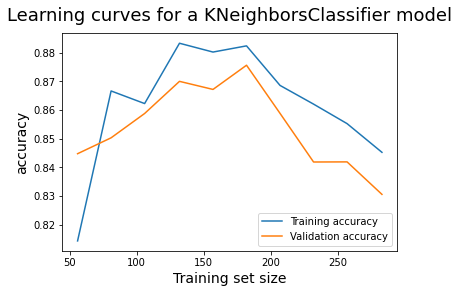

In [11]:
learning_curves(model, X_train, y_train, np.linspace(0.2, 1.0, 10), 5, scoring = "accuracy")

#### Saving predictions and probablilities for model comparison:

In [12]:
pd.DataFrame(y_test_pred).to_csv('results/knn_pred.csv', index=False)
pd.DataFrame(model.predict_proba(X_test)[:,1]).to_csv('results/knn_prob.csv', index=False)

#### Saving model:

In [13]:
joblib.dump(model, 'models/knnModel.joblib')

['models/knnModel.joblib']

### ROC curve - for train and for test data

In [14]:
Encoder = LabelEncoder()
y_train = Encoder.fit_transform(y_train)
y_test = Encoder.fit_transform(y_test)

In [15]:
#test data
y_score1 = model.predict_proba(X_test)[:,1]
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, y_score1)
test_score = round(roc_auc_score(y_test, y_score1), 2)
#train data
y_score2 = model.predict_proba(X_train)[:,1]
false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(y_train, y_score2)
val_score = round(roc_auc_score(y_train, y_score2), 2)

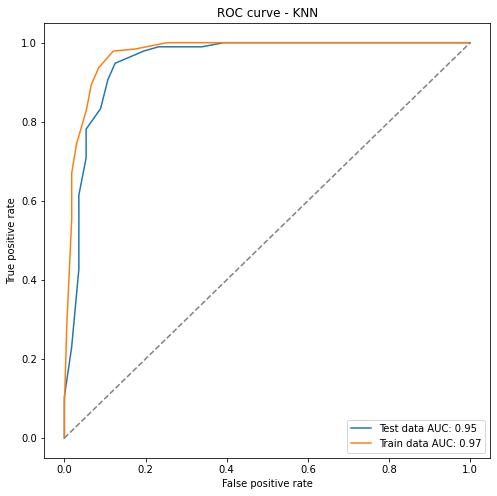

In [16]:
plt.subplots(1, figsize=(8,8))
plt.title('ROC curve - KNN')
#roc curve for test data
plt.plot(false_positive_rate1, true_positive_rate1, label="Test data AUC: " + str(test_score))
#roc curve for val data
plt.plot(false_positive_rate2, true_positive_rate2, label="Train data AUC: " + str(val_score))
plt.plot([0, 1], ls="--", color='gray')
plt.legend(loc='lower right')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

# KNN and reduced data

In [17]:
K = 13

Reducing data using SVD:

In [18]:
svd = TruncatedSVD(n_components=5)
reduced_data = svd.fit_transform(X_train)

Creating ang trainign model on reduced data:

In [19]:
model = KNeighborsClassifier(n_neighbors=K)
model.fit(reduced_data, y_train)

KNeighborsClassifier(n_neighbors=13)

Prediction on training set:

In [20]:
y_train_pred = model.predict(reduced_data)
report(y_train, y_train_pred)

Confusion matrix: 
 [[141  25]
 [ 23 165]]

Classification report: 
               precision    recall  f1-score   support

           0       0.86      0.85      0.85       166
           1       0.87      0.88      0.87       188

    accuracy                           0.86       354
   macro avg       0.86      0.86      0.86       354
weighted avg       0.86      0.86      0.86       354



### Testing model:

Reducing test data:

In [21]:
reduced_test = svd.fit_transform(X_test)

Testing:

In [22]:
y_test_pred = model.predict(reduced_test)
report(y_test, y_test_pred)

Confusion matrix: 
 [[27 29]
 [ 1 95]]

Classification report: 
               precision    recall  f1-score   support

           0       0.96      0.48      0.64        56
           1       0.77      0.99      0.86        96

    accuracy                           0.80       152
   macro avg       0.87      0.74      0.75       152
weighted avg       0.84      0.80      0.78       152

